In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
DATA_DIR = "C:/Users/Yakina/.cache/kagglehub/datasets/mdwaquarazam/agricultural-crops-image-classification/versions/1/Agricultural-crops"

In [3]:
BATCH_SIZE = 32
NUM_WORKERS = 2
IMG_SIZE = 224

In [4]:
# Data augmentations
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [5]:
# Load dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
class_names = full_dataset.classes
num_classes = len(class_names)

In [6]:
# Train-val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [7]:
# Apply validation transform
val_dataset.dataset.transform = val_transform

In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Load ResNet18
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze pretrained layers

c:\Users\Yakina\anaconda3\envs\traineeship\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Yakina\anaconda3\envs\traineeship\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Replace final FC layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [13]:
EPOCHS = 20

In [14]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}')


Epoch 1/20, Loss: 3.3128, Accuracy: 0.1011
Epoch 2/20, Loss: 2.5790, Accuracy: 0.3424
Epoch 3/20, Loss: 2.0284, Accuracy: 0.6063
Epoch 4/20, Loss: 1.6408, Accuracy: 0.7044
Epoch 5/20, Loss: 1.3419, Accuracy: 0.7934
Epoch 6/20, Loss: 1.1695, Accuracy: 0.8130
Epoch 7/20, Loss: 0.9957, Accuracy: 0.8477
Epoch 8/20, Loss: 0.8913, Accuracy: 0.8778
Epoch 9/20, Loss: 0.7754, Accuracy: 0.8899
Epoch 10/20, Loss: 0.7216, Accuracy: 0.8944
Epoch 11/20, Loss: 0.6357, Accuracy: 0.9186
Epoch 12/20, Loss: 0.5524, Accuracy: 0.9306
Epoch 13/20, Loss: 0.5049, Accuracy: 0.9608
Epoch 14/20, Loss: 0.4685, Accuracy: 0.9532
Epoch 15/20, Loss: 0.4436, Accuracy: 0.9623
Epoch 16/20, Loss: 0.3983, Accuracy: 0.9713
Epoch 17/20, Loss: 0.3817, Accuracy: 0.9698
Epoch 18/20, Loss: 0.3354, Accuracy: 0.9864
Epoch 19/20, Loss: 0.3252, Accuracy: 0.9759
Epoch 20/20, Loss: 0.3120, Accuracy: 0.9819


In [15]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [16]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                     precision    recall  f1-score   support

             Cherry       0.89      0.89      0.89         9
       Coffee-plant       0.50      0.33      0.40         6
           Cucumber       0.67      0.86      0.75         7
   Fox_nut(Makhana)       0.50      0.67      0.57         3
              Lemon       0.71      1.00      0.83         5
         Olive-tree       0.67      0.80      0.73        10
Pearl_millet(bajra)       0.75      0.67      0.71         9
      Tobacco-plant       0.62      0.83      0.71         6
             almond       0.83      0.83      0.83         6
             banana       0.75      0.75      0.75         4
           cardamom       0.75      0.43      0.55         7
             chilli       1.00      0.50      0.67         4
              clove       0.50      0.80      0.62         5
            coconut       1.00      0.88      0.93         8
             cotton       0.86      0.75      0.80         8


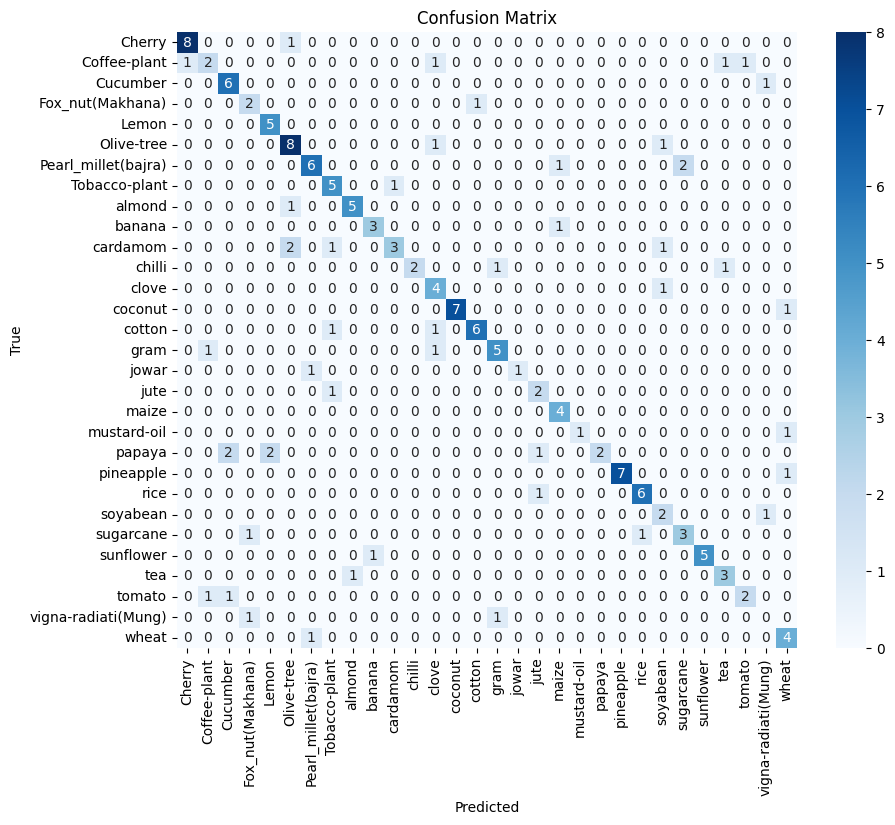

In [17]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()